In [75]:
import cv2
import numpy as np
import os
import tensorflow as tf
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from keras.models import model_from_json
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint


In [3]:
train_dir = os.path.join( 'dataset/train')
validation_dir = os.path.join('dataset/test')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

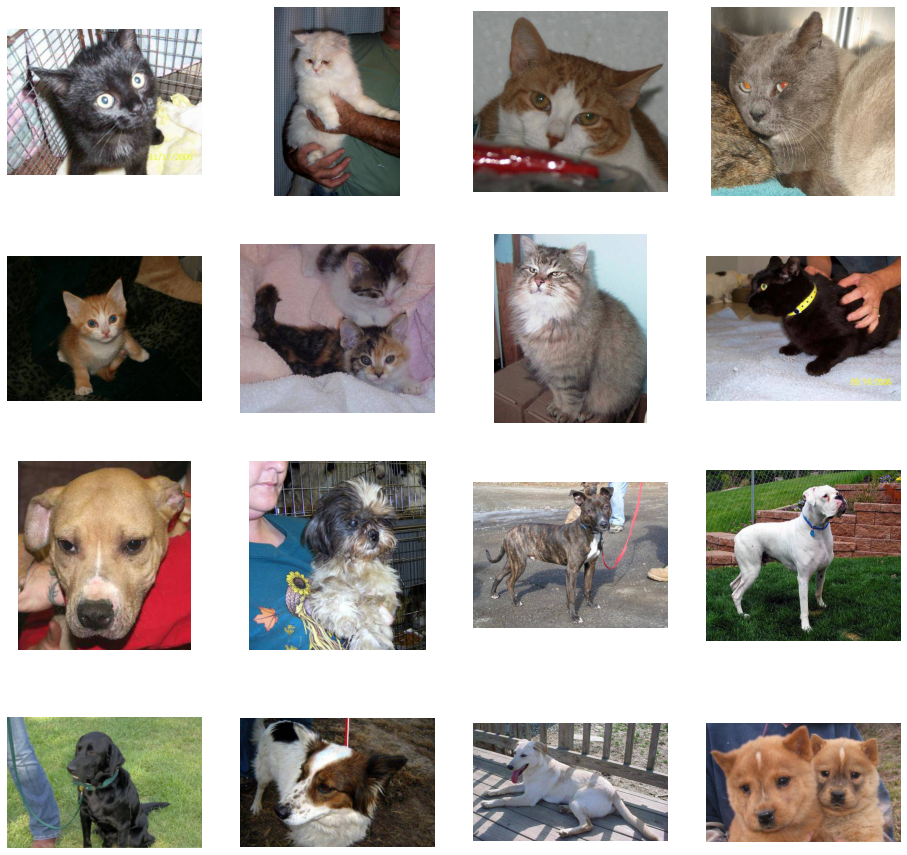

In [6]:
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )


next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## VGG-16 Model

In [9]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [10]:
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory( validation_dir,  batch_size = 20, class_mode = 'binary', target_size = (224, 224))

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [11]:
base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

58889256/58889256 [==============================] - 39s 1us/step


In [13]:
for layer in base_model.layers:
    layer.trainable = False

In [21]:
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

C:\Users\aneas\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [22]:
vgghist = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)


Epoch 1/10
100/100 [==============================] - 975s 10s/step - loss: 0.6895 - acc: 0.6800 - val_loss: 0.3322 - val_acc: 0.8595
Epoch 2/10
100/100 [==============================] - 961s 10s/step - loss: 0.4678 - acc: 0.7845 - val_loss: 0.4453 - val_acc: 0.7835
Epoch 3/10
100/100 [==============================] - 992s 10s/step - loss: 0.4236 - acc: 0.8125 - val_loss: 0.2525 - val_acc: 0.8915
Epoch 4/10
100/100 [==============================] - 986s 10s/step - loss: 0.4169 - acc: 0.8055 - val_loss: 0.2355 - val_acc: 0.9000
Epoch 5/10
100/100 [==============================] - 961s 10s/step - loss: 0.3971 - acc: 0.8215 - val_loss: 0.3108 - val_acc: 0.8655
Epoch 6/10
100/100 [==============================] - 957s 10s/step - loss: 0.3690 - acc: 0.8390 - val_loss: 0.3432 - val_acc: 0.8500
Epoch 7/10
100/100 [==============================] - 957s 10s/step - loss: 0.3566 - acc: 0.8380 - val_loss: 0.2095 - val_acc: 0.9085
Epoch 8/10
100/100 [==============================] - 977s 10s

## Inception Model


In [23]:
train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2,shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [24]:
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (150, 150))
validation_generator = test_datagen.flow_from_directory(validation_dir, batch_size = 20, class_mode = 'binary', target_size = (150, 150))

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [27]:
base_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')

87910968/87910968 [==============================] - 58s 1us/step


In [28]:
for layer in base_model.layers:
    layer.trainable = False
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(lr=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

In [30]:
inc_history = model.fit_generator(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)

Epoch 1/10


C:\Users\aneas\AppData\Local\Temp\ipykernel_9676\3455053356.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  inc_history = model.fit_generator(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)


100/100 [==============================] - 114s 1s/step - loss: 0.5444 - acc: 0.8770 - val_loss: 0.1230 - val_acc: 0.9570
Epoch 2/10
100/100 [==============================] - 113s 1s/step - loss: 0.3755 - acc: 0.8940 - val_loss: 0.1147 - val_acc: 0.9590
Epoch 3/10
100/100 [==============================] - 113s 1s/step - loss: 0.3929 - acc: 0.8820 - val_loss: 0.1074 - val_acc: 0.9565
Epoch 4/10
100/100 [==============================] - 113s 1s/step - loss: 0.3621 - acc: 0.9000 - val_loss: 0.2039 - val_acc: 0.9465
Epoch 5/10
100/100 [==============================] - 113s 1s/step - loss: 0.3256 - acc: 0.9080 - val_loss: 0.1262 - val_acc: 0.9585
Epoch 6/10
100/100 [==============================] - 114s 1s/step - loss: 0.3160 - acc: 0.9145 - val_loss: 0.2290 - val_acc: 0.9480
Epoch 7/10
100/100 [==============================] - 114s 1s/step - loss: 0.3060 - acc: 0.9130 - val_loss: 0.2311 - val_acc: 0.9470
Epoch 8/10
100/100 [==============================] - 114s 1s/step - loss: 0.299

## ResNet50 Model

In [70]:
train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

validation_generator = test_datagen.flow_from_directory( validation_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [71]:
base_model = ResNet50(input_shape=(224, 224,3), include_top=False, weights="imagenet")


In [72]:
for layer in base_model.layers:
    layer.trainable = False

In [73]:

base_model = Sequential()
base_model.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
base_model.add(Dense(1, activation='sigmoid'))


In [78]:
base_model.compile(optimizer = tf.keras.optimizers.SGD(lr=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

In [79]:
resnet_history = base_model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)


Epoch 1/10
100/100 [==============================] - 1018s 10s/step - loss: 1.4605 - acc: 0.6525 - val_loss: 1.7333 - val_acc: 0.4985
Epoch 2/10
100/100 [==============================] - 1037s 10s/step - loss: 0.6981 - acc: 0.8135 - val_loss: 1.7318 - val_acc: 0.4785
Epoch 3/10
100/100 [==============================] - 1031s 10s/step - loss: 0.5094 - acc: 0.8635 - val_loss: 1.4875 - val_acc: 0.4270
Epoch 4/10
100/100 [==============================] - 1019s 10s/step - loss: 0.4121 - acc: 0.8865 - val_loss: 1.7748 - val_acc: 0.4640
Epoch 5/10
100/100 [==============================] - 1019s 10s/step - loss: 0.4263 - acc: 0.8990 - val_loss: 1.7543 - val_acc: 0.5375
Epoch 6/10
100/100 [==============================] - 1019s 10s/step - loss: 0.3809 - acc: 0.9040 - val_loss: 1.2930 - val_acc: 0.6705
Epoch 7/10
100/100 [==============================] - 1018s 10s/step - loss: 0.3060 - acc: 0.9205 - val_loss: 0.9950 - val_acc: 0.7890
Epoch 8/10
100/100 [==============================] - 1